# Imports

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import matplotlib.pyplot as plt
# TODO: seeding

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Conv1D, SeparableConv1D, MaxPooling1D, Activation

Using TensorFlow backend.


# Function to Read Data

In [2]:
def read_data(suffix=''):
    
    x_train_df = pd.read_csv('x_train' + suffix + '.csv', index_col=0)
    x_test_df = pd.read_csv('x_test' + suffix + '.csv', index_col=0)
    y_train_series = pd.read_csv('y_train' + suffix + '.csv', index_col=0, header=None)
    y_test_series = pd.read_csv('y_test' + suffix + '.csv', index_col=0, header=None)

    # Just grab the values for training.
    x_train = x_train_df.values
    x_test = x_test_df.values
    y_train = y_train_series.values
    y_test = y_test_series.values
    print('Data loaded.')
    
    return x_train, y_train, x_test, y_test

# Read all data

In [3]:
# We're reading all the data first so that when we create our new "images" they
# can simply be pointers to this data, instead of containing it all.
x_tr_s, y_tr_s, x_te_s, y_te_s = read_data(suffix='')
# x_tr_mm, y_tr_mm, x_te_mm, y_te_mm = read_data(suffix='_mm')
# x_tr_both, y_tr_both, x_te_both, y_te_both = read_data(suffix='_both')
# print('All data loaded.')

Data loaded.


# Constants for Reshaping

In [4]:
# How many weeks are we using for batches?
num_weeks = 4

# How many full weeks do we have?
five_min_per_week = int((1/5) * 60 * 24 * 7)
# Given the shape of our data, how many weeks are there? (round down)
weeks_train = np.floor(x_tr_s.shape[0] / five_min_per_week).astype(int)
weeks_test = np.floor(x_te_s.shape[0] / five_min_per_week).astype(int)
# Given how many weeks we have and assuming we train with 4 week batches, how
# many batches will we have?
batches_train = int(np.floor(weeks_train) / num_weeks)
batches_test = int(np.floor(weeks_test) / num_weeks)
# Determine the ending index of the data we'll keep (trim off the end)
keep_train = five_min_per_week * batches_train
keep_test = five_min_per_week * batches_test
# Number of timesteps in a "month"
t_per_m = five_min_per_week * num_weeks
# Num features for convenience.
num_f = x_tr_s.shape[1]

# How many timesteps are we predicting?
num_y=12*24

print('Constants for reshaping defined.')

# Keep memory trim
del x_tr_s, y_tr_s, x_te_s, y_te_s

Constants for reshaping defined.


# Reshape Data

In [5]:
# For the training data, we'll create 1000 "images" by randomly drawing starting positions.
np.random.seed(37)

def get_starting_indices(num_images, data_length, n_y):
    # Create array from 0 to the number of training samples minus one month minus the number of training samples
    start_arr = np.arange(start=0, stop=data_length - t_per_m - n_y, dtype=int)

    return np.random.choice(start_arr, size=num_images, replace=False)

In [6]:
# Reshape the data!
def reshape_xy(x_in, y_in, n_y, s):
    """
    x_in: x data
    y_in: y data
    num_y: number of y samples we'll be predicting. E.g., 12 to predict for 1 hour.
    s: array of starting indices.
    """
    # Arrange data so we have (batch, height, width, channels).
    x_out = np.zeros((len(s), num_weeks, five_min_per_week, x_in.shape[1]))
    
    # We'll predict some numbers of samples.
    y_out = np.zeros((len(s), n_y))
    
    # Loop over each starting index.
    for i, s_idx in enumerate(s):
        # Compute ending index.
        e_idx = s_idx + t_per_m
        
        # Loop over the features.
        for f in range(x_in.shape[1]):
            # Extract data.
            d = x_in[s_idx:e_idx, f]
            
            # Reshape it.
            d_r = np.reshape(d, newshape=(num_weeks, five_min_per_week))
            
            # Dump it into the reshaped x array.
            x_out[i, :, :, f] = d_r
            
        # Extract the approprate y data.
        y_out[i, :] = y_in[e_idx:e_idx + n_y].ravel()
    
    # All done.
    return x_out, y_out

In [7]:
def load_and_reshape(suffix, n_y):
#     # Do nasty hard-coding for data selection.
#     if suffix == '':
#         x_tr, y_tr, x_te, y_te = x_tr_s, y_tr_s, x_te_s, y_te_s
#     elif suffix == '_mm':
#         x_tr, y_tr, x_te, y_te = x_tr_mm, y_tr_mm, x_te_mm, y_te_mm
#     elif suffix == '_both':
#         x_tr, y_tr, x_te, y_te = x_tr_both, y_tr_both, x_te_both, y_te_both
#     else:
#         raise UserWarning('You fat-fingered it and typed the suffix wrong.')

    x_tr, y_tr, x_te, y_te = read_data(suffix=suffix)

    # r suffix for 'reshaped'
    # 5000 is what fits in memory. Why it isn't making efficient pointers, I don't know.
    train_start = get_starting_indices(num_images=5000, data_length=x_tr.shape[0], n_y=n_y)
    x_trr, y_trr = reshape_xy(x_in=x_tr, y_in=y_tr, n_y=n_y, s=train_start)

    test_start = get_starting_indices(num_images=500, data_length=x_te.shape[0], n_y=n_y)
    x_ter, y_ter = reshape_xy(x_in=x_te, y_in=y_te, n_y=n_y, s=test_start)
    
    print('Data reshaped.')
    
    return x_trr, y_trr, x_ter, y_ter

# Function to Initialize 2D CNN, Early Stopping

In [8]:
def init_cnn(x_shape, y_shape):
    # If training is taking too long, we may want to switch to 'SeperableConv2D'
    # layers instead of simply Conv2D
    model = Sequential()
    # kernel size of 12, 4 will give us 12 5 minutes intervals and 4 weeks if the 
    # data is arranged in a weekly format.
    # 
    # Using strides of 3, 1 so we traverse 15 minutes of data at a time.
    input_shape = (num_weeks, five_min_per_week, num_f)
    print('Input shape: {}'.format(input_shape))
    model.add(Conv2D(filters=16, kernel_size=(2, 36), strides=1,
                     padding='same', data_format='channels_last',
                     input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(MaxPooling2D((1, 12)))
    model.add(Conv2D(filters=16, kernel_size=(2, 3), strides=1,
                     padding='same', data_format='channels_last'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 12)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(y_shape[1], activation='relu'))

    model.compile(loss=keras.losses.mean_squared_error, optimizer='Adam',
                  metrics=['mse'])
    print(model.summary())
    return model

# Create early stopping callback.
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [9]:
def train_predict(suffix):
    x_tr, y_tr, x_te, y_te = load_and_reshape(suffix=suffix, n_y=num_y)
    
    cnn = init_cnn(x_shape=x_tr.shape, y_shape=y_tr.shape)
    
    cnn.fit(x_tr, y_tr, epochs=100, shuffle=True, validation_split=0.2, callbacks=[early_stop])
    
    # Keep memory light
    del x_tr, y_tr
    
    y_pred = cnn.predict(x_te)
    
    return y_pred, x_te, y_te

In [10]:
def plot(y_p, x_t, y_t):
    
    plt.scatter(y_t, y_p)
    
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('2D CNN Predicted vs. Actual')
    plt.plot([y_t.min(), y_t.max()], [y_t.min(), y_t.max()])

# CNN With Standard Scaled Data

In [11]:
# y_pred_s, x_te_s, y_te_s = train_predict(suffix='')

In [12]:
# plot(y_p=y_pred_s, x_t=x_te_s, y_t=y_te_s)

In [13]:
# Clear up memory.
# del y_pred_s, x_te_s, y_te_s

# CNN With Min/Max Scaling

In [14]:
y_pred_mm, x_te_mm, y_te_mm = train_predict(suffix='_mm')

Data loaded.
Data reshaped.
Input shape: (4, 2016, 18)
Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 4, 2016, 16)       20752     
_________________________________________________________________
activation_1 (Activation)    (None, 4, 2016, 16)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 168, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 168, 16)        1552      
_________________________________________________________________
activation_2 (Activation)    (None, 4, 168, 16)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 14, 16)         0         
_______________

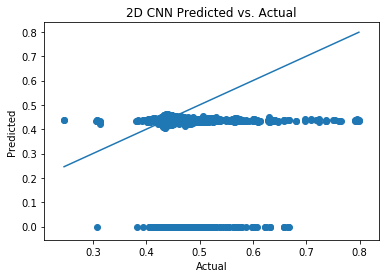

In [15]:
plot(y_p=y_pred_mm, x_t=x_te_mm, y_t=y_te_mm)

In [16]:
# Clear up memory
# del y_pred_mm, x_te_mm, y_te_mm

# CNN With Both Scaling

In [17]:
# y_pred_both, x_te_both, y_te_both = train_predict(suffix='_both')

In [18]:
# plot(y_p=y_pred_both, x_t=x_te_both, y_t=y_te_both)

# Metrics, Plotting, etc.

In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.externals import joblib

# Load scaler objects which data_prep wrote.
standard_y = joblib.load('standard_scaler_y.save')
# standard_x = joblib.load('standard_scaler_x.save')
minmax_y = joblib.load('min_max_scaler_y.save')
# minmax_x = joblib.load('min_max_scaler_x.save')
both_y = joblib.load('both_scaler_y.save')
# both_x = joblib.load('both_scaler_x.save')

In [20]:
def eval_metrics(y_true, y_pred, scaler, scaler2=None):
    y_true_scaled = scaler.inverse_transform(y_true)
    y_pred_scaled = scaler.inverse_transform(y_pred)
    
    if scaler2 is not None:
        y_true_scaled = scaler2.inverse_transform(y_true_scaled)
        y_pred_scaled = scaler2.inverse_transform(y_pred_scaled)
    
    mae = mean_absolute_error(y_true=y_true_scaled,
                              y_pred=y_pred_scaled)
    mse = mean_squared_error(y_true=y_true_scaled,
                             y_pred=y_pred_scaled)
    r2 = r2_score(y_true=y_true_scaled,
                  y_pred=y_pred_scaled)
    
    print('MAE: {:.4f}'.format(mae))
    print('MSE: {:.4f}'.format(mse))
    print('R2:  {:.4f}'.format(r2))
    
    plt.plot(np.arange(0, len(y_true_scaled)), y_true_scaled, y_pred_scaled)
    plt.legend(['True', 'Predicted'])
    plt.xlabel('Time (5-minute intervals for 2018)')
    plt.ylabel('Price (USD)')
    return y_true_scaled, y_pred_scaled

## Min/Max Scaling (Standard failed to learn, ran out of memory to do both)

NOTE: This is not the true time series of the test data!
Instead, it is 500 test months
MAE: 499.7132
MSE: 953585.5054
R2:  -3021.2291


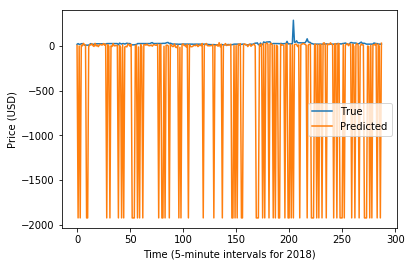

In [28]:
print('NOTE: This is not the true time series of the test data!')
print('Instead, it is 500 test months')
y_true = y_te_mm.flatten().reshape(-1, 1)
y_pred = y_pred_mm.flatten().reshape(-1, 1)
y_true_standard, y_pred_standard = \
    eval_metrics(y_true=y_true[0:num_y], y_pred=y_pred[0:num_y], scaler=minmax_y)